<a href="https://colab.research.google.com/github/MS-H2020/Open/blob/main/Brain_Tumor_Detection_using_YOLO_v10.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# [Brain tumor object detection datasets](https://www.kaggle.com/datasets/davidbroberts/brain-tumor-object-detection-datasets)

## Refference

[Brain Tumor Detection using YOLO v10](https://www.kaggle.com/code/metinmekiabullrahman/brain-tumor-detection-using-yolo-v10)

## 0. Setting for Google Colab

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
!pip install ultralytics
!pip install wandb
import ultralytics
from ultralytics import YOLO
import pandas as pd
import numpy as np
import os
import cv2
import matplotlib.pyplot as plt
import random
import wandb
wandb.init(mode="disabled")
import shutil

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 802.9/802.9 kB 8.8 MB/s eta 0:00:00
  Using cached nvidia_cuda_nvrtc_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (23.7 MB)
  Using cached nvidia_cuda_runtime_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (823 kB)
  Using cached nvidia_cuda_cupti_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (14.1 MB)
  Using cached nvidia_cudnn_cu12-8.9.2.26-py3-none-manylinux1_x86_64.whl (731.7 MB)
  Using cached nvidia_cublas_cu12-12.1.3.1-py3-none-manylinux1_x86_64.whl (410.6 MB)
  Using cached nvidia_cufft_cu12-11.0.2.54-py3-none-manylinux1_x86_64.whl (121.6 MB)
  Using cached nvidia_curand_cu12-10.3.2.106-py3-none-manylinux1_x86_64.whl (56.5 MB)
  Using cached nvidia_cusolver_cu12-11.4.5.107-py3-none-manylinux1_x86_64.whl (124.2 MB)
  Using cached nvidia_cusparse_cu12-12.1.0.106-py3-none-manylinux1_x86_64.whl (196.0 MB)
  Using cached nvidia_nccl_cu12-2.20.5-py3-none-manylinux2014_x86_64.whl (176.2 MB)
  Using cached nvidia_nvtx_cu12-12.1.105-py3-none-m

In [4]:
import shutil
shutil.unpack_archive('/content/drive/MyDrive/Brain_Tumor/axial_t1wce_2_class.zip', './')
#shutil.unpack_archive('/content/drive/MyDrive/Brain_Tumor/coronal_t1wce_2_class.zip', './')
#shutil.unpack_archive('/content/drive/MyDrive/Brain_Tumor/sagittal_t1wce_2_class.zip', './')

In [7]:
files = os.listdir('./axial_t1wce_2_class/images/train')
random_file = random.choice(files)
random_file = os.path.splitext(random_file)[0]
print(random_file)

00130_81


In [9]:
with open(os.path.join('./axial_t1wce_2_class/labels/train', f'{random_file}.txt'),'r') as f:
    labels = f.readlines()
    labels = labels[0].split(' ')
    f.close()

(256, 256, 3)


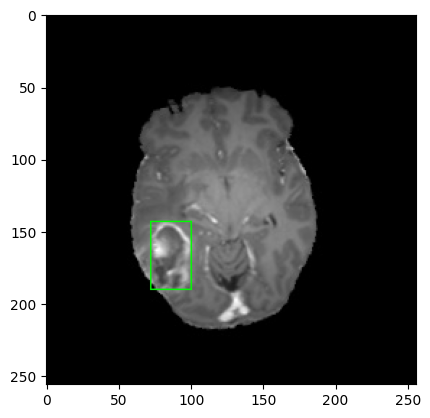

In [10]:
img = cv2.imread(os.path.join('./axial_t1wce_2_class/images/train', f'{random_file}.jpg'), 1)
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

tumor_class, x, y, w, h = int(labels[0]), float(labels[1]), float(labels[2]), float(labels[3]), float(labels[4])
x_pt1 = int((x - w/2) * img.shape[1])
y_pt1 = int((y - h/2) * img.shape[0])
x_pt2 = int((x + w/2) * img.shape[1])
y_pt2 = int((y + h/2) * img.shape[0])

if tumor_class == 1:
    colour = (255, 0, 0)
else:
    colour = (0, 255, 0)
cv2.rectangle(img, (x_pt1, y_pt1), (x_pt2, y_pt2), colour, 1)

print(img.shape)
plt.imshow(img)

In [11]:
train_images = os.listdir('./axial_t1wce_2_class/images/train')
test_images = os.listdir('./axial_t1wce_2_class/images/test')
train_labels = os.listdir('./axial_t1wce_2_class/labels/train')
test_labels = os.listdir('./axial_t1wce_2_class/labels/test')

num_train_images = len(train_images)
num_test_images = len(test_images)
num_train_labels = len(train_labels)
num_test_labels = len(test_labels)

print(num_train_images, num_test_images)
print(num_train_labels, num_test_labels)

310 75
296 75


In [12]:
os.path.splitext(random_file)[0]
unlabelled = set(train_images) - set([os.path.splitext(file)[0] + '.jpg' for file in train_labels])

for image in unlabelled:
    os.remove(os.path.join('./axial_t1wce_2_class/images/train', image))

In [13]:
train_images = os.listdir('./axial_t1wce_2_class/images/train')
test_images = os.listdir('./axial_t1wce_2_class/images/test')
train_labels = os.listdir('./axial_t1wce_2_class/labels/train')
test_labels = os.listdir('./axial_t1wce_2_class/images/test')

num_train_images = len(train_images)
num_test_images = len(test_images)
num_train_labels = len(train_labels)
num_test_labels = len(test_labels)

print(num_train_images, num_test_images)
print(num_train_labels, num_test_labels)

296 75
296 75


In [14]:
val_split = int(num_train_images * 0.2)
val_images = random.sample(train_images, val_split)

if os.path.exists('./axial_t1wce_2_class/images/val'):
    shutil.rmtree('./axial_t1wce_2_class/images/val')
if os.path.exists('./axial_t1wce_2_class/labels/val'):
    shutil.rmtree('./axial_t1wce_2_class/labels/val')

os.mkdir('././axial_t1wce_2_class/images/val')
os.mkdir('././axial_t1wce_2_class/labels/val')

for image in val_images:
    shutil.move(os.path.join('./axial_t1wce_2_class/images/train', image), './axial_t1wce_2_class/images/val')

for image in val_images:
    label = os.path.splitext(image)[0] + '.txt'
    shutil.move(os.path.join('./axial_t1wce_2_class/labels/train', label), './axial_t1wce_2_class/labels/val')

In [15]:
text ="""
path: ../axial_t1wce_2_class
train: images/train
val: images/test

# Classes
nc: 2
names: ['negative','positive']
"""

with open('./fixed_path.yaml', 'w') as file:
    file.write(text)

In [16]:
model = YOLO('yolov10s.pt')

100%|██████████| 15.9M/15.9M [00:00<00:00, 251MB/s]


In [17]:
results = model.train(data='./fixed_path.yaml', batch=-1, epochs=50, device=0)

Ultralytics YOLOv8.2.60 🚀 Python-3.10.12 torch-2.3.1+cu121 CUDA:0 (Tesla T4, 15102MiB)
engine/trainer: task=detect, mode=train, model=yolov10s.pt, data=./fixed_path.yaml, epochs=50, time=None, patience=100, batch=-1, imgsz=640, save=True, save_period=-1, cache=False, device=0, workers=8, project=None, name=train, exist_ok=False, pretrained=True, optimizer=auto, verbose=True, seed=0, deterministic=True, single_cls=False, rect=False, cos_lr=False, close_mosaic=10, resume=False, amp=True, fraction=1.0, profile=False, freeze=None, multi_scale=False, overlap_mask=True, mask_ratio=4, dropout=0.0, val=True, split=val, save_json=False, save_hybrid=False, conf=None, iou=0.7, max_det=300, half=False, dnn=False, plots=True, source=None, vid_stride=1, stream_buffer=False, visualize=False, augment=False, agnostic_nms=False, classes=None, retina_masks=False, embed=None, show=False, save_frames=False, save_txt=False, save_conf=False, save_crop=False, show_labels=True, show_conf=True, show_boxes=True,

100%|██████████| 755k/755k [00:00<00:00, 27.5MB/s]


Overriding model.yaml nc=80 with nc=2

                   from  n    params  module                                       arguments                     
  0                  -1  1       928  ultralytics.nn.modules.conv.Conv             [3, 32, 3, 2]                 
  1                  -1  1     18560  ultralytics.nn.modules.conv.Conv             [32, 64, 3, 2]                
  2                  -1  1     29056  ultralytics.nn.modules.block.C2f             [64, 64, 1, True]             
  3                  -1  1     73984  ultralytics.nn.modules.conv.Conv             [64, 128, 3, 2]               
  4                  -1  2    197632  ultralytics.nn.modules.block.C2f             [128, 128, 2, True]           
  5                  -1  1     36096  ultralytics.nn.modules.block.SCDown          [128, 256, 3, 2]              
  6                  -1  2    788480  ultralytics.nn.modules.block.C2f             [256, 256, 2, True]           
  7                  -1  1    137728  ultralytics

100%|██████████| 6.25M/6.25M [00:00<00:00, 112MB/s]


AMP: checks passed ✅
AutoBatch: Computing optimal batch size for imgsz=640 at 60.0% CUDA memory utilization.
AutoBatch: CUDA:0 (Tesla T4) 14.75G total, 0.25G reserved, 0.10G allocated, 14.39G free
      Params      GFLOPs  GPU_mem (GB)  forward (ms) backward (ms)                   input                  output
     8067900       24.77         0.682         46.17           nan        (1, 3, 640, 640)                    list
     8067900       49.55         1.267         38.62           nan        (2, 3, 640, 640)                    list
     8067900        99.1         2.462         41.27           nan        (4, 3, 640, 640)                    list
     8067900       198.2         4.706         64.08           nan        (8, 3, 640, 640)                    list
     8067900       396.4         9.091         94.04           nan       (16, 3, 640, 640)                    list
AutoBatch: Using batch-size 15 for CUDA:0 8.92G/14.75G (60%) ✅


train: Scanning /content/axial_t1wce_2_class/labels/train... 237 images, 0 backgrounds, 0 corrupt: 100%|██████████| 237/237 [00:00<00:00, 1909.62it/s]

train: New cache created: /content/axial_t1wce_2_class/labels/train.cache


albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01), CLAHE(p=0.01, clip_limit=(1, 4.0), tile_grid_size=(8, 8))


/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
val: Scanning /content/axial_t1wce_2_class/labels/test... 75 images, 0 backgrounds, 0 corrupt: 100%|██████████| 75/75 [00:00<00:00, 706.25it/s]

val: New cache created: /content/axial_t1wce_2_class/labels/test.cache


Plotting labels to runs/detect/train/labels.jpg... 
optimizer: 'optimizer=auto' found, ignoring 'lr0=0.01' and 'momentum=0.937' and determining best 'optimizer', 'lr0' and 'momentum' automatically... 
optimizer: AdamW(lr=0.001667, momentum=0.9) with parameter groups 99 weight(decay=0.0), 112 weight(decay=0.00046875), 111 bias(decay=0.0)
TensorBoard: model graph visualization added ✅
Image sizes 640 train, 640 val
Using 2 dataloader workers
Logging results to runs/detect/train
Starting training for 50 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       1/50      5.26G      3.546      35.03      3.119         19        640: 100%|██████████| 16/16 [00:11<00:00,  1.37it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:04<00:00,  1.42s/it]

                   all         75         81      0.064      0.259      0.103     0.0878



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       2/50      5.23G      2.484      12.83       2.34         23        640: 100%|██████████| 16/16 [00:06<00:00,  2.66it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  4.05it/s]


                   all         75         81     0.0385      0.642     0.0318     0.0223

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       3/50      5.24G      2.475      5.968      2.311         22        640: 100%|██████████| 16/16 [00:08<00:00,  1.86it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  2.67it/s]

                   all         75         81      0.701      0.346      0.404      0.215



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       4/50      5.24G      2.686      4.567      2.425         29        640: 100%|██████████| 16/16 [00:08<00:00,  1.89it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  3.95it/s]

                   all         75         81      0.491       0.19      0.284      0.169



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       5/50      5.24G      2.532      3.539      2.412         19        640: 100%|██████████| 16/16 [00:05<00:00,  3.06it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  3.96it/s]


                   all         75         81      0.491       0.19      0.284      0.169

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       6/50      5.24G      2.784      3.837      2.571         25        640: 100%|██████████| 16/16 [00:07<00:00,  2.07it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:02<00:00,  1.44it/s]

                   all         75         81      0.229      0.173      0.113     0.0599



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       7/50      5.24G      3.056      3.761      2.697         19        640: 100%|██████████| 16/16 [00:05<00:00,  3.07it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  3.55it/s]

                   all         75         81      0.646      0.444      0.472      0.249



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       8/50      5.24G      2.777      3.561      2.492         15        640: 100%|██████████| 16/16 [00:06<00:00,  2.46it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  2.64it/s]

                   all         75         81      0.653      0.506      0.527      0.291



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       9/50      5.24G      2.551      2.993      2.403         18        640: 100%|██████████| 16/16 [00:06<00:00,  2.35it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  3.98it/s]

                   all         75         81      0.617      0.642      0.625       0.36



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      10/50      5.24G      2.575      2.914      2.462         26        640: 100%|██████████| 16/16 [00:05<00:00,  3.08it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  3.24it/s]


                   all         75         81      0.743      0.543      0.656       0.44

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      11/50      5.24G      2.473      2.725      2.424         30        640: 100%|██████████| 16/16 [00:07<00:00,  2.04it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  4.00it/s]

                   all         75         81      0.861      0.382       0.51      0.329



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      12/50      5.24G      2.479      2.705      2.404         18        640: 100%|██████████| 16/16 [00:05<00:00,  3.11it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  3.84it/s]

                   all         75         81      0.528      0.568      0.573      0.358



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      13/50      5.24G      2.539      2.748      2.458         13        640: 100%|██████████| 16/16 [00:07<00:00,  2.07it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  2.65it/s]

                   all         75         81      0.619       0.63       0.65      0.411



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      14/50      5.24G       2.38      2.541      2.317         23        640: 100%|██████████| 16/16 [00:05<00:00,  3.05it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  3.73it/s]

                   all         75         81      0.433      0.272      0.297      0.179



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      15/50      5.24G      2.399      2.373      2.292         22        640: 100%|██████████| 16/16 [00:06<00:00,  2.44it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  2.51it/s]

                   all         75         81      0.177      0.185      0.127      0.081



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      16/50      5.24G      2.332      2.476      2.336         15        640: 100%|██████████| 16/16 [00:06<00:00,  2.62it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  3.35it/s]

                   all         75         81      0.841      0.679        0.8      0.538



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      17/50      5.24G      2.375      2.367      2.332         23        640: 100%|██████████| 16/16 [00:08<00:00,  1.89it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  2.48it/s]

                   all         75         81      0.578      0.491      0.555      0.347



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      18/50      5.24G      2.325       2.32      2.296         20        640: 100%|██████████| 16/16 [00:07<00:00,  2.19it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  3.90it/s]

                   all         75         81      0.704      0.616      0.682       0.47



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      19/50      5.24G      2.237      2.218      2.223         21        640: 100%|██████████| 16/16 [00:08<00:00,  1.94it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  2.35it/s]

                   all         75         81      0.821      0.738      0.836      0.527



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      20/50      5.24G      2.189      2.046      2.265         18        640: 100%|██████████| 16/16 [00:08<00:00,  1.92it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  4.02it/s]

                   all         75         81      0.695      0.691      0.763      0.547



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      21/50      5.24G      2.299      2.113      2.312         23        640: 100%|██████████| 16/16 [00:05<00:00,  3.01it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  3.94it/s]

                   all         75         81      0.589      0.496      0.545      0.339



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      22/50      5.24G      2.245      2.249      2.301         19        640: 100%|██████████| 16/16 [00:07<00:00,  2.19it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  2.83it/s]

                   all         75         81      0.632      0.728      0.637      0.376



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      23/50      5.24G      2.143      2.028      2.169         23        640: 100%|██████████| 16/16 [00:05<00:00,  3.04it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  3.78it/s]

                   all         75         81      0.847      0.765      0.834       0.56



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      24/50      5.24G      2.206      1.854      2.231         17        640: 100%|██████████| 16/16 [00:06<00:00,  2.54it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  2.92it/s]

                   all         75         81      0.765      0.724      0.785      0.521



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      25/50      5.24G      2.174      2.193      2.255         22        640: 100%|██████████| 16/16 [00:06<00:00,  2.51it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  3.96it/s]

                   all         75         81      0.014      0.802     0.0196     0.0128



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      26/50      5.24G      2.089      2.072      2.154         23        640: 100%|██████████| 16/16 [00:05<00:00,  2.99it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  3.07it/s]

                   all         75         81      0.217      0.185      0.108     0.0589



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      27/50      5.24G      2.166      1.969      2.218         22        640: 100%|██████████| 16/16 [00:07<00:00,  2.11it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  3.53it/s]

                   all         75         81      0.802        0.5      0.723      0.443



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      28/50      5.24G      2.005      1.871      2.128         22        640: 100%|██████████| 16/16 [00:05<00:00,  2.99it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  3.92it/s]

                   all         75         81      0.854      0.797      0.883      0.598



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      29/50      5.24G      2.089      1.927      2.172         17        640: 100%|██████████| 16/16 [00:07<00:00,  2.04it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  3.25it/s]

                   all         75         81      0.327      0.457      0.379      0.229



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      30/50      5.24G      2.093      1.809      2.155         19        640: 100%|██████████| 16/16 [00:05<00:00,  3.08it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  4.04it/s]

                   all         75         81      0.799      0.691      0.786      0.536



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      31/50      5.24G      2.067      1.752      2.136         23        640: 100%|██████████| 16/16 [00:06<00:00,  2.32it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  2.54it/s]

                   all         75         81      0.722       0.63      0.736      0.479



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      32/50      5.24G      2.048      1.778      2.147         25        640: 100%|██████████| 16/16 [00:05<00:00,  3.09it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  3.90it/s]

                   all         75         81      0.133      0.852      0.327       0.22



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      33/50      5.24G      2.028       1.68      2.182         12        640: 100%|██████████| 16/16 [00:06<00:00,  2.54it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  2.63it/s]

                   all         75         81      0.753      0.413       0.61        0.4



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      34/50      5.24G       1.89      1.527      2.074         31        640: 100%|██████████| 16/16 [00:08<00:00,  1.87it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  2.80it/s]

                   all         75         81      0.756      0.535      0.744      0.491



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      35/50      5.24G      1.909      1.523      2.072         21        640: 100%|██████████| 16/16 [00:05<00:00,  3.05it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  3.77it/s]

                   all         75         81      0.715      0.683      0.753      0.493



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      36/50      5.24G        1.8      1.391      2.004         23        640: 100%|██████████| 16/16 [00:08<00:00,  1.80it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  2.58it/s]

                   all         75         81      0.722      0.771      0.813      0.542



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      37/50      5.24G      1.861      1.559      2.054         21        640: 100%|██████████| 16/16 [00:06<00:00,  2.41it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  3.95it/s]

                   all         75         81      0.813       0.75      0.843       0.58



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      38/50      5.24G      1.853      1.384      2.066         21        640: 100%|██████████| 16/16 [00:05<00:00,  3.06it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  3.29it/s]

                   all         75         81      0.748      0.842      0.819      0.537



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      39/50      5.24G      1.752      1.358      1.999         18        640: 100%|██████████| 16/16 [00:07<00:00,  2.09it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  3.86it/s]

                   all         75         81       0.78      0.753      0.822      0.569



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      40/50      5.24G      1.847       1.37       2.09         27        640: 100%|██████████| 16/16 [00:05<00:00,  3.06it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  4.02it/s]

                   all         75         81      0.811      0.728       0.81      0.536


Closing dataloader mosaic
albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01), CLAHE(p=0.01, clip_limit=(1, 4.0), tile_grid_size=(8, 8))


/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      41/50      5.24G      1.644      1.178      1.999         12        640: 100%|██████████| 16/16 [00:10<00:00,  1.49it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  3.92it/s]

                   all         75         81      0.518      0.889      0.756      0.492



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      42/50      5.24G      1.577      1.163      1.938         12        640: 100%|██████████| 16/16 [00:05<00:00,  3.05it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  3.98it/s]

                   all         75         81      0.794      0.667      0.813      0.521



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      43/50      5.24G      1.595      1.194      1.952         12        640: 100%|██████████| 16/16 [00:07<00:00,  2.17it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  2.91it/s]

                   all         75         81      0.538      0.963      0.801      0.517



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      44/50      5.24G      1.601      1.116      1.962         12        640: 100%|██████████| 16/16 [00:05<00:00,  2.86it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  4.03it/s]

                   all         75         81      0.818      0.667      0.823      0.556



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      45/50      5.24G      1.543      1.059      1.954         14        640: 100%|██████████| 16/16 [00:05<00:00,  2.90it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  2.86it/s]

                   all         75         81       0.86      0.682      0.852      0.573



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      46/50      5.24G      1.512     0.8924      1.951         12        640: 100%|██████████| 16/16 [00:07<00:00,  2.14it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  4.05it/s]

                   all         75         81       0.84      0.765      0.867      0.585



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      47/50      5.24G      1.521      1.018      1.977         12        640: 100%|██████████| 16/16 [00:05<00:00,  3.13it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  3.87it/s]

                   all         75         81      0.857      0.778      0.883       0.62



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      48/50      5.24G      1.469     0.9163      1.948         12        640: 100%|██████████| 16/16 [00:07<00:00,  2.22it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  2.67it/s]

                   all         75         81      0.876      0.699      0.865      0.588



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      49/50      5.24G      1.495     0.8774      1.934         13        640: 100%|██████████| 16/16 [00:05<00:00,  3.05it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  3.59it/s]

                   all         75         81      0.868       0.65      0.861       0.58



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      50/50      5.24G      1.436     0.8501      1.905         12        640: 100%|██████████| 16/16 [00:07<00:00,  2.23it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  2.58it/s]

                   all         75         81      0.832      0.704      0.848      0.578



50 epochs completed in 0.139 hours.
Optimizer stripped from runs/detect/train/weights/last.pt, 16.5MB
Optimizer stripped from runs/detect/train/weights/best.pt, 16.5MB

Validating runs/detect/train/weights/best.pt...
Ultralytics YOLOv8.2.60 🚀 Python-3.10.12 torch-2.3.1+cu121 CUDA:0 (Tesla T4, 15102MiB)
YOLOv10s summary (fused): 293 layers, 8,036,508 parameters, 0 gradients, 24.4 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:02<00:00,  1.41it/s]


                   all         75         81      0.862       0.79      0.883      0.619
              negative         75         81      0.862       0.79      0.883      0.619
Speed: 0.4ms preprocess, 6.9ms inference, 0.0ms loss, 0.7ms postprocess per image
Results saved to runs/detect/train


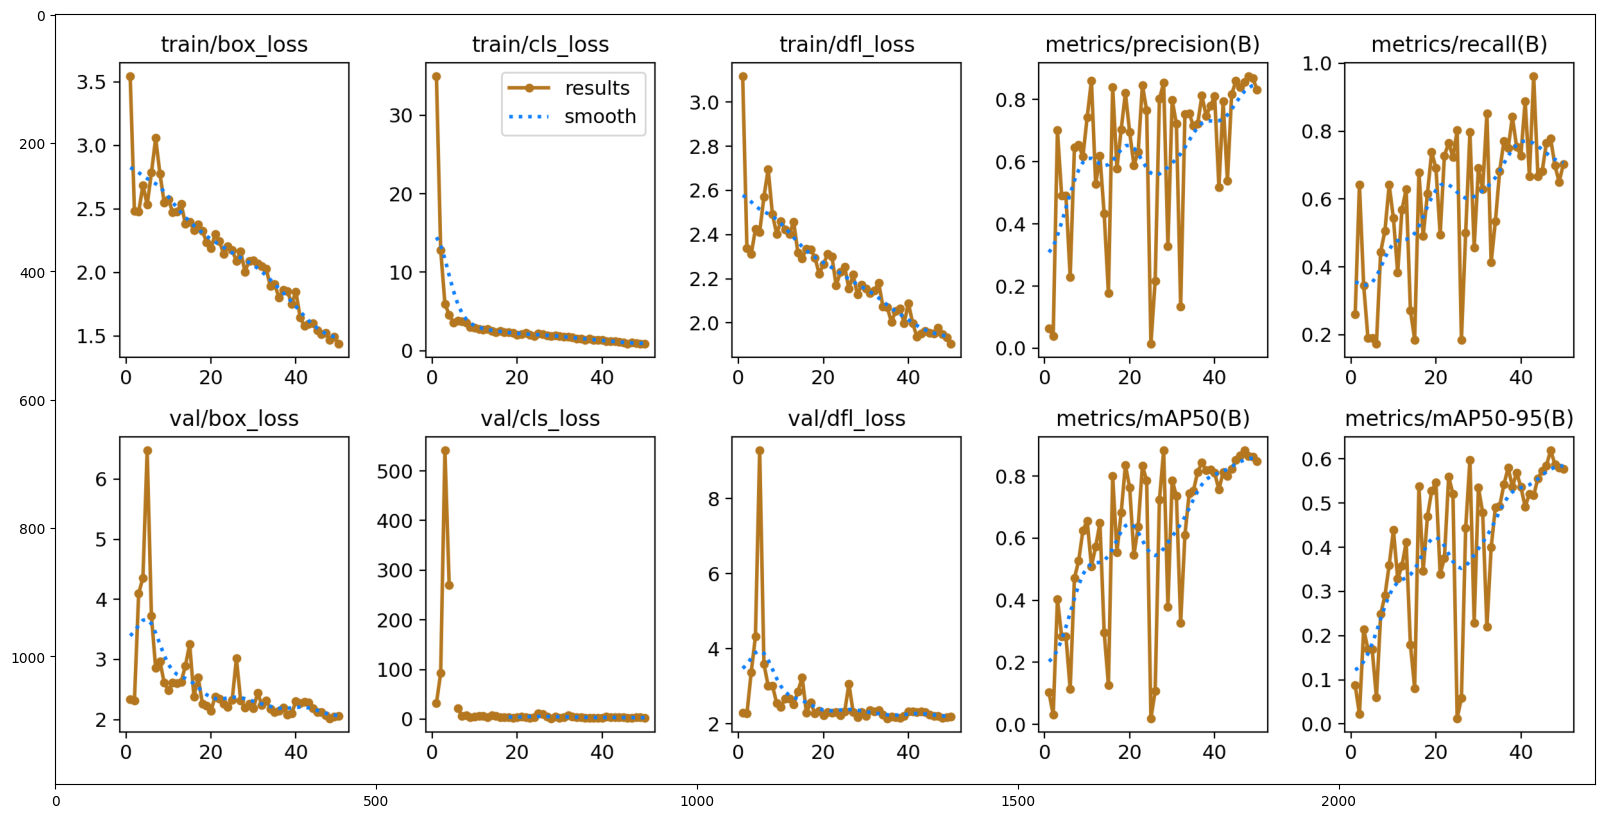

In [18]:
training_save_dir = './' + str(results.save_dir)

plt.figure(figsize=(20, 10))
img = cv2.imread(os.path.join(training_save_dir, 'results.png'))
plt.imshow(img)
plt.show()

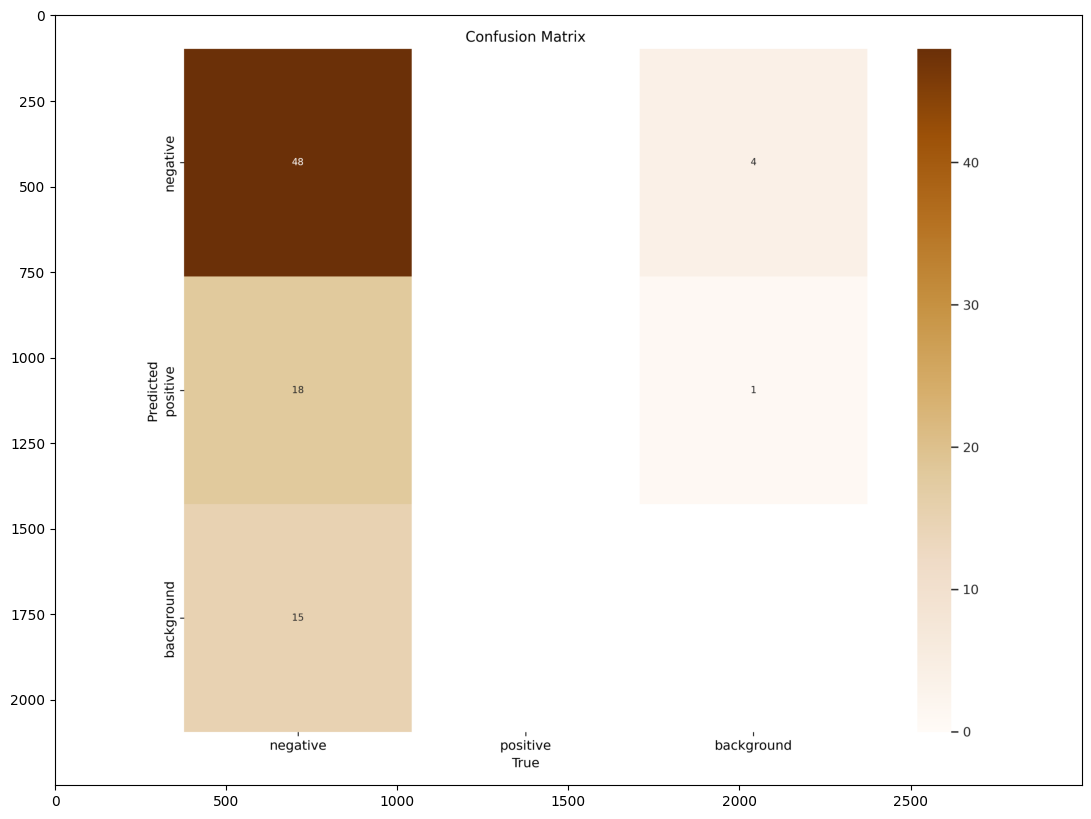

In [19]:
plt.figure(figsize=(20, 10))
img = cv2.imread(os.path.join(training_save_dir, 'confusion_matrix.png'))
plt.imshow(img)
plt.show()

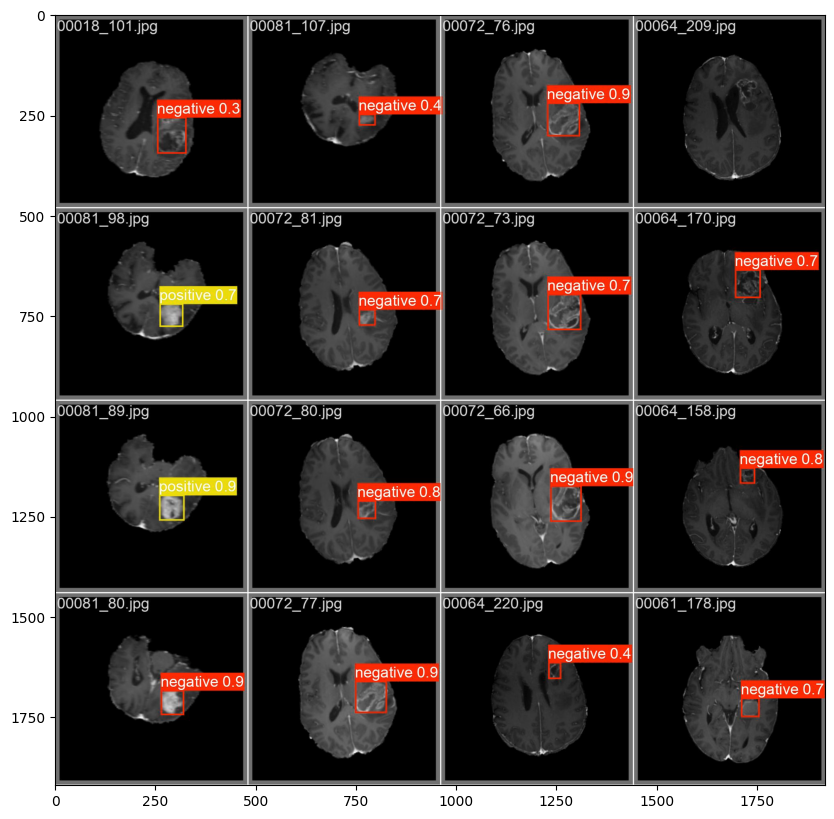

In [20]:
plt.figure(figsize=(20, 10))
img = cv2.imread(os.path.join(training_save_dir, 'val_batch0_pred.jpg'))
plt.imshow(img)
plt.show()

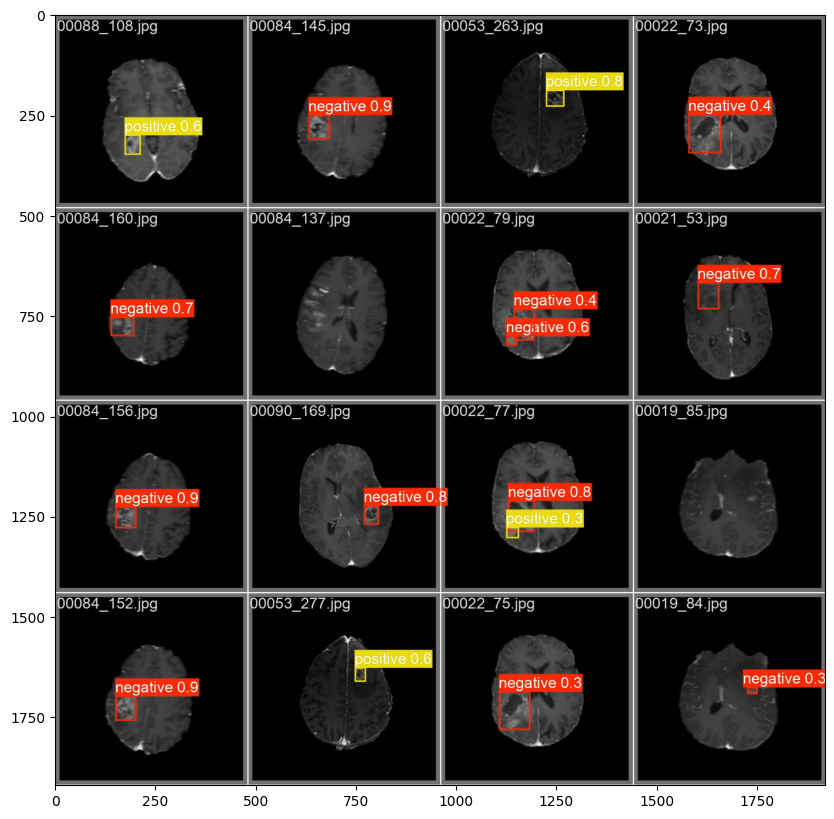

In [21]:
plt.figure(figsize=(20, 10))
img = cv2.imread(os.path.join(training_save_dir, 'val_batch1_pred.jpg'))
plt.imshow(img)
plt.show()

In [22]:
trained_model = YOLO(training_save_dir + '/weights/best.pt')
predictions = trained_model.predict(
    source="./axial_t1wce_2_class/images/test",
    conf=0.4, save_txt=True, save_conf=True)


image 1/75 /content/axial_t1wce_2_class/images/test/00018_101.jpg: 640x640 (no detections), 24.2ms
image 2/75 /content/axial_t1wce_2_class/images/test/00018_109.jpg: 640x640 1 negative, 23.4ms
image 3/75 /content/axial_t1wce_2_class/images/test/00018_111.jpg: 640x640 1 negative, 25.8ms
image 4/75 /content/axial_t1wce_2_class/images/test/00018_117.jpg: 640x640 1 negative, 18.8ms
image 5/75 /content/axial_t1wce_2_class/images/test/00018_121.jpg: 640x640 1 negative, 23.2ms
image 6/75 /content/axial_t1wce_2_class/images/test/00018_126.jpg: 640x640 1 negative, 26.5ms
image 7/75 /content/axial_t1wce_2_class/images/test/00018_134.jpg: 640x640 (no detections), 21.0ms
image 8/75 /content/axial_t1wce_2_class/images/test/00019_66.jpg: 640x640 1 negative, 29.6ms
image 9/75 /content/axial_t1wce_2_class/images/test/00019_75.jpg: 640x640 1 negative, 20.8ms
image 10/75 /content/axial_t1wce_2_class/images/test/00019_84.jpg: 640x640 (no detections), 19.4ms
image 11/75 /content/axial_t1wce_2_class/image

In [23]:
predictions_save_dir = './' + predictions[0].save_dir + '/labels'

In [24]:
def draw_bbox(file_path, filename, img):
    with open(os.path.join(file_path, f'{filename}.txt'),'r') as f:
        labels = f.readlines()
        labels = labels[0].split(' ')
        print(labels)
        f.close()

    tumor_class, x, y, w, h = int(labels[0]), float(labels[1]), float(labels[2]), float(labels[3]), float(labels[4])
    x_pt1 = int((x - w/2) * img.shape[1])
    y_pt1 = int((y - h/2) * img.shape[0])
    x_pt2 = int((x + w/2) * img.shape[1])
    y_pt2 = int((y + h/2) * img.shape[0])

    if tumor_class == 0:
        colour = (255, 0, 0)
        label = 'Negative'
    else:
        colour = (0, 255, 0)
        label = 'Positive'
    if len(labels) > 5:
        prob = float(labels[5])
        prob = round(prob, 1)
        prob = str(prob)
        label = label + ' ' + prob

    cv2.rectangle(img, (x_pt1, y_pt1), (x_pt2, y_pt2), colour, 1)
    cv2.putText(img, label, (x_pt1, y_pt1 - 5), cv2.FONT_HERSHEY_SIMPLEX, 0.4, colour, 1)

['0', '0.625803', '0.509338', '0.0780379', '0.0923094', '0.601371\n']
['0', '0.521127', '0.472418', '0.103286', '0.073944\n']


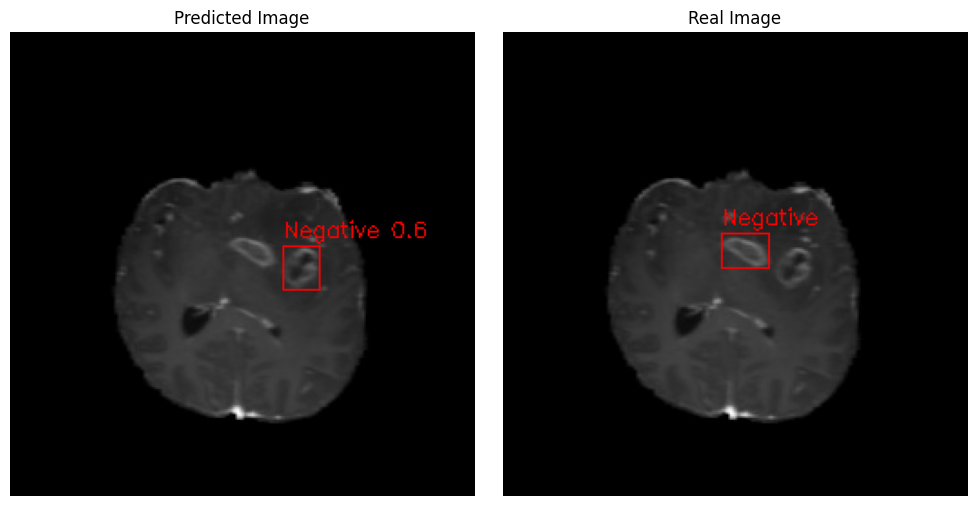

In [25]:
files = os.listdir(predictions_save_dir)
random_file = random.choice(files)
random_file = os.path.splitext(random_file)[0]

img_pred = cv2.imread(os.path.join('./axial_t1wce_2_class/images/test', f'{random_file}.jpg'), 1)
img_pred = cv2.cvtColor(img_pred, cv2.COLOR_BGR2RGB)
draw_bbox(predictions_save_dir, random_file, img_pred)

img_real = cv2.imread(os.path.join('./axial_t1wce_2_class/images/test', f'{random_file}.jpg'), 1)
img_real = cv2.cvtColor(img_real, cv2.COLOR_BGR2RGB)
draw_bbox('./axial_t1wce_2_class/labels/test', random_file, img_real)

fig, axes = plt.subplots(1, 2, figsize=(10, 5))

axes[0].imshow(img_pred)
axes[0].set_title('Predicted Image')
axes[0].axis('off')

axes[1].imshow(img_real)
axes[1].set_title('Real Image')
axes[1].axis('off')

plt.tight_layout()
plt.show()

In [26]:
text = """
path: ../axial_t1wce_2_class
train: images/train
val: images/test

# Classes
nc: 2
names: ['negative','positive']
"""
with open("./test.yaml", 'w') as file:
    file.write(text)

In [27]:
metrics = trained_model.val(data="./test.yaml")

Ultralytics YOLOv8.2.60 🚀 Python-3.10.12 torch-2.3.1+cu121 CUDA:0 (Tesla T4, 15102MiB)


val: Scanning /content/axial_t1wce_2_class/labels/test.cache... 75 images, 0 backgrounds, 0 corrupt: 100%|██████████| 75/75 [00:00<?, ?it/s]
/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:04<00:00,  1.04it/s]


                   all         75         81      0.857      0.778      0.883       0.62
              negative         75         81      0.857      0.778      0.883       0.62
Speed: 0.7ms preprocess, 32.8ms inference, 0.0ms loss, 1.4ms postprocess per image
Results saved to runs/detect/val


In [28]:
test_save_dir = './' + str(metrics.save_dir)

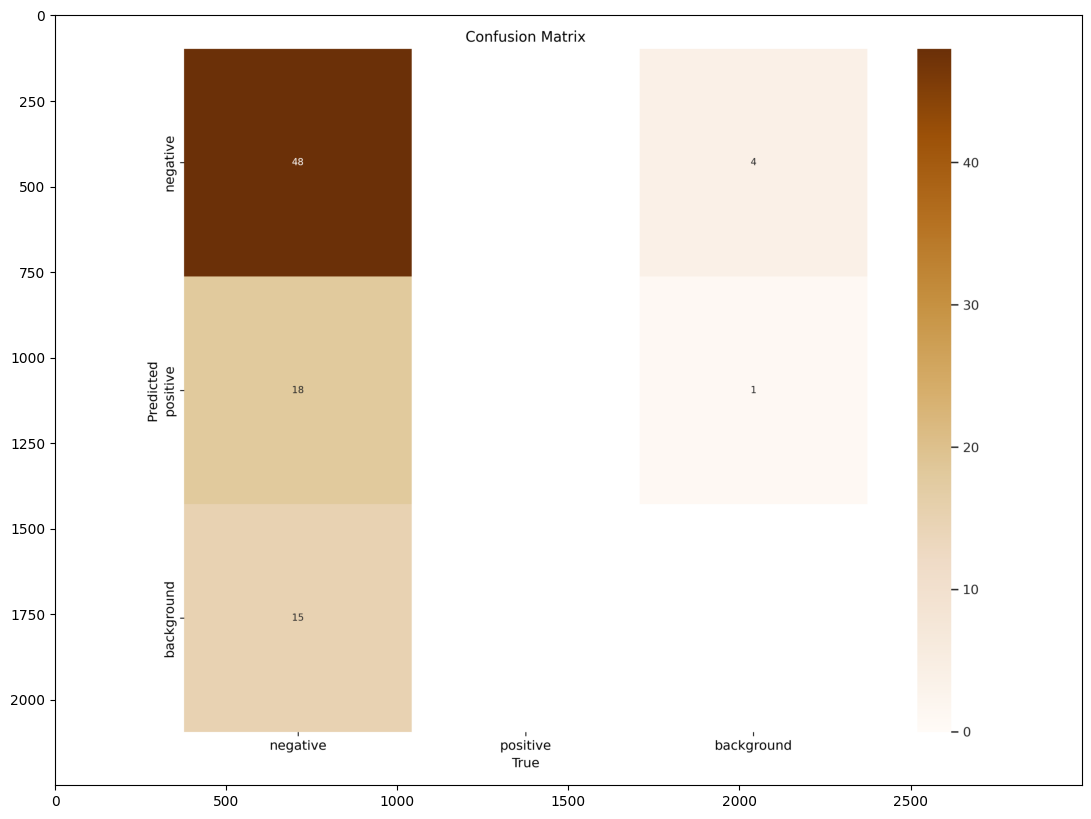

In [29]:
plt.figure(figsize=(20, 10))
img = cv2.imread(os.path.join(test_save_dir, 'confusion_matrix.png'))
plt.imshow(img)
plt.show()

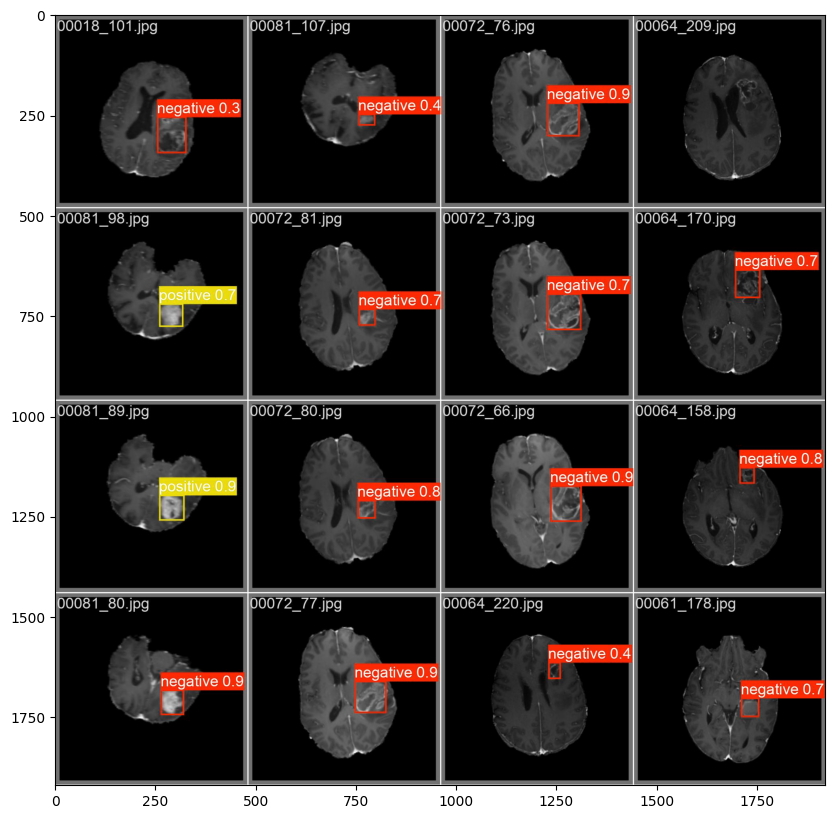

In [30]:
plt.figure(figsize=(20, 10))
img = cv2.imread(os.path.join(test_save_dir, 'val_batch0_pred.jpg'))
plt.imshow(img)
plt.show()

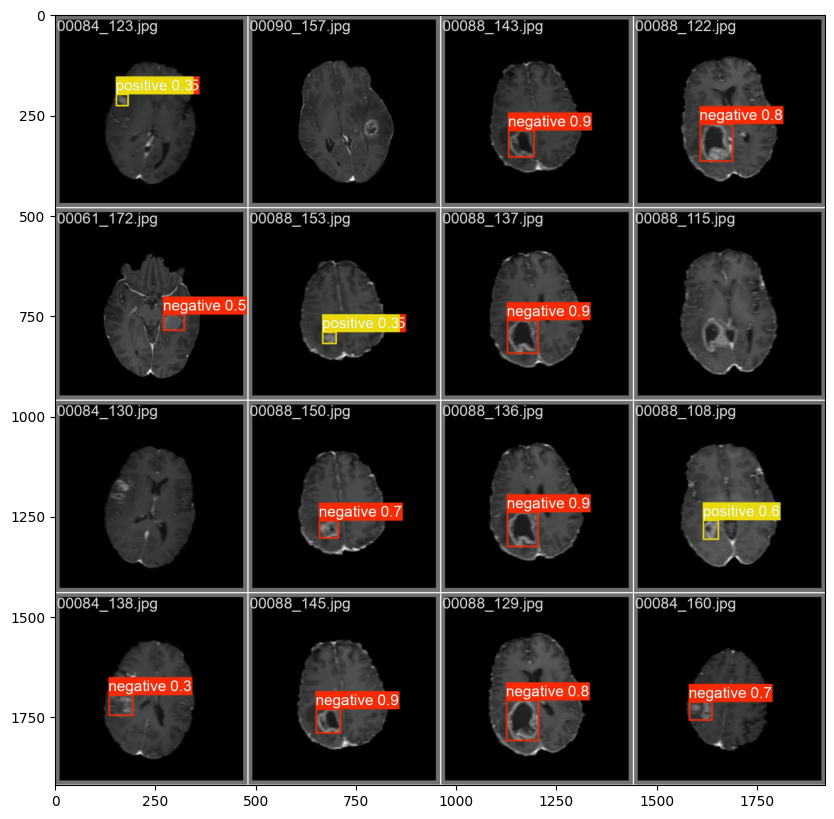

In [31]:
plt.figure(figsize=(20, 10))
img = cv2.imread(os.path.join(test_save_dir, 'val_batch1_pred.jpg'))
plt.imshow(img)
plt.show()

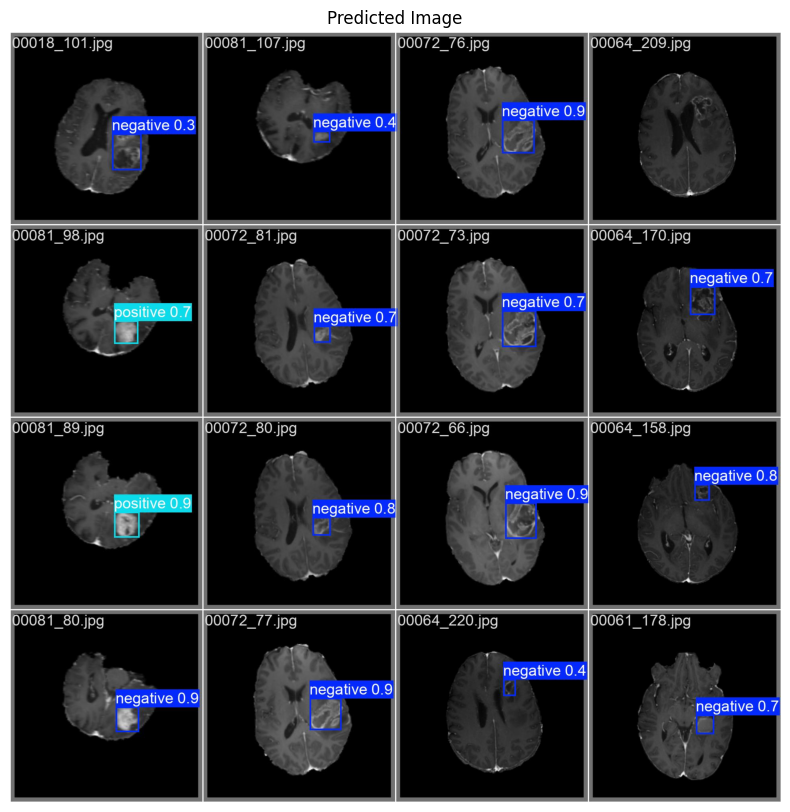

In [32]:
image_path = os.path.join(test_save_dir, 'val_batch0_pred.jpg')

# Create a figure with a specified size
plt.figure(figsize=(20, 10))

# Read the image using OpenCV
img = cv2.imread(image_path)

# Display the image using matplotlib
plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))  # Convert BGR to RGB for correct display

# Add a title to the plot (optional)
plt.title('Predicted Image')

# Show the plot
plt.axis('off')  # Hide axis ticks and labels
plt.show()